In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms, get_rms_no_outliers

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch 0: train loss 4.43e+08, val loss 4.36e+08


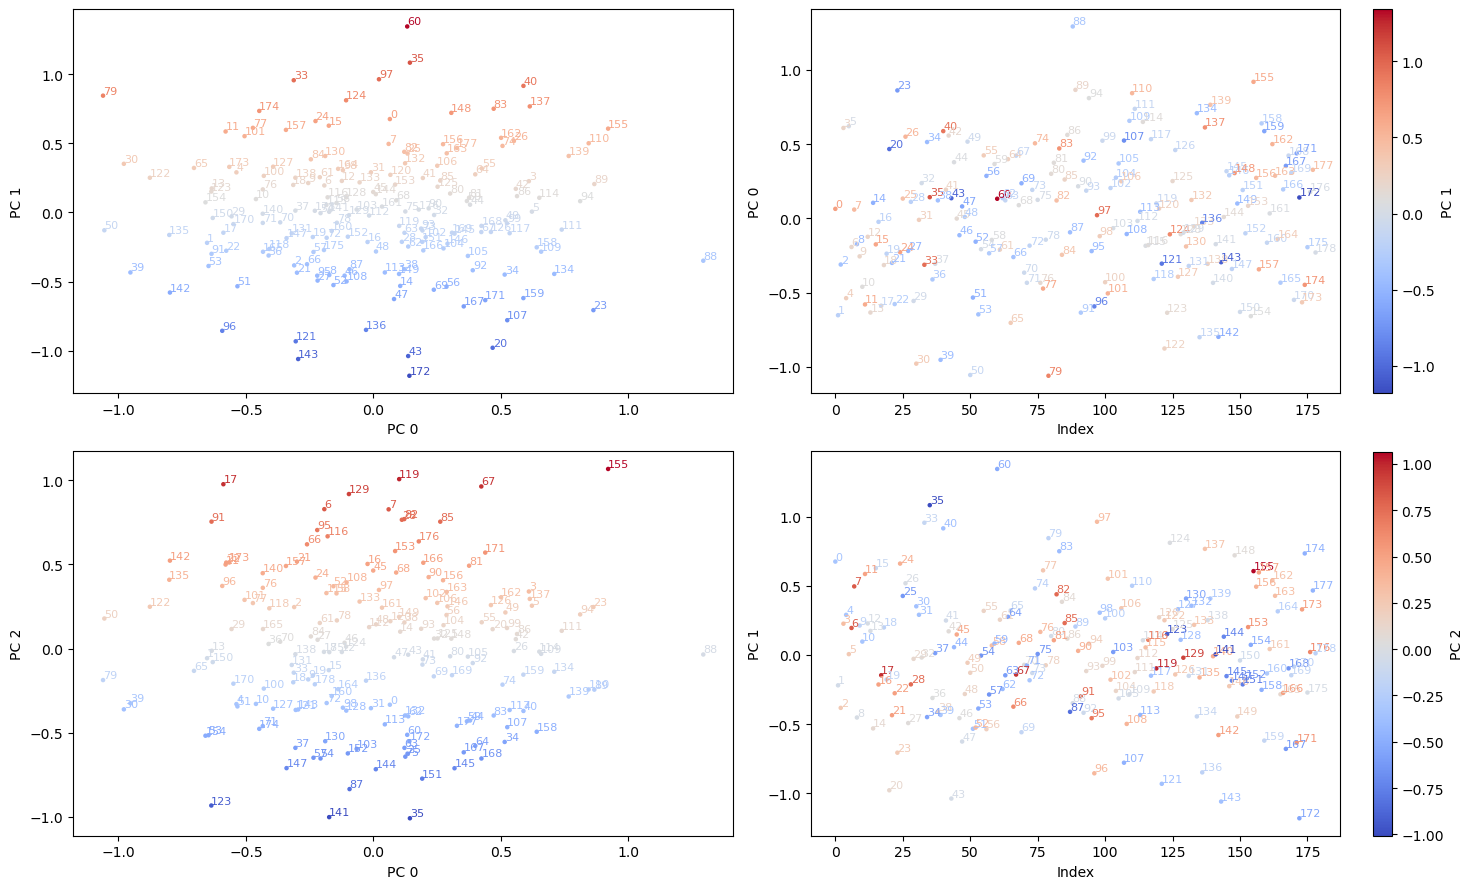

Epoch 5000: train loss 1.07e+04, val loss 7.04e+04


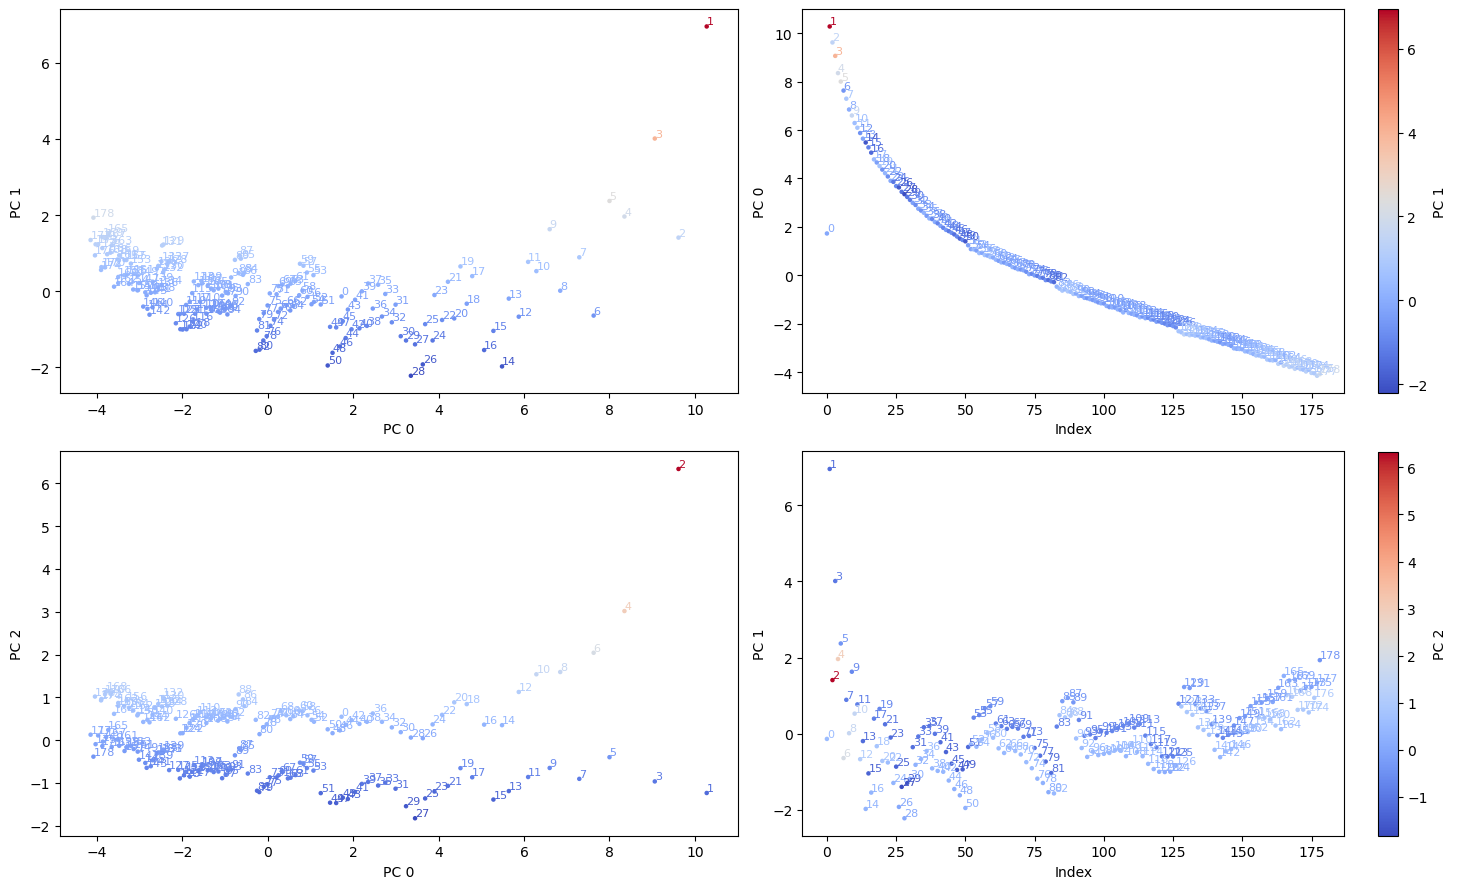

KeyboardInterrupt: 

In [15]:
# loop
wd = "small"
bs = 20
for task in ["all"]:
    experiment_name = f"generalization_perf_small_models-wd{wd}-{bs}/{task}"
    os.makedirs("experiments", exist_ok=True)
    os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
    if task == "all":
        task_dict = {
            "binding": 100,
            "z": 1,
            "n": 1,
            "radius": 0.02,
            "qa": 200,
            "qbm": 200,
            "qbm_n": 200,
            "qec": 200,
            "sn": 200,
            "sp": 200,
        }
    else:
        task_dict = {task: 100}
    args = {
        "DEPTH": 1,
        "DEV": (device := "cuda"),
        "EPOCHS": 100_000,
        "HIDDEN_DIM": 2048,
        "LR": 1e-3,
        "MODEL": "baseline",
        "SIGMOID_READOUT": "false",
        "TMS": "remove",
        "WD": {"small": 1e-8, "medium": 1e-4, "large": 1e-1}[wd],
        "LIPSCHITZ": "false",
        "DEV": "cuda",
        "TARGETS_CLASSIFICATION": {},
        "TARGETS_REGRESSION": task_dict,
        "TRAIN_SET": "random",  # random, all_data, extrap_1, extrap_2, extrap_3
        "TRAIN_FRAC": 0.8,
        "BATCH_SIZE": bs/100,
        "LOG_TIMES": 10,
        "NUCLEI_GE": 0,
        "NUCLEI_HIGH_UNC": "keep",
        "PER_NUCLEON": "true",
        "SEED": 0,
    }

    args = Namespace(**args)

    # IO.save_args(args, f"experiments/{experiment_name}/args.yaml")

    data = prepare_nuclear_data(args)

    # setup data
    X_train = data.X[data.train_mask]
    y_train = data.y[data.train_mask]
    non_nan_targets = ~torch.isnan(y_train.view(-1))
    X_train = X_train[non_nan_targets]
    y_train = y_train[non_nan_targets]

    X_val = data.X[data.val_mask]
    y_val = data.y[data.val_mask]
    non_nan_targets = ~torch.isnan(y_val.view(-1))
    X_val = X_val[non_nan_targets]
    y_val = y_val[non_nan_targets]

    torch.manual_seed(1)
    new_model, optim_model = get_model_and_optim(data, args)

    # train the new model
    epochs = args.EPOCHS
    task_name = list(data.output_map.keys())[0]
    scale = 1 / torch.tensor(list(args.TARGETS_REGRESSION.values()), device=args.DEV)

    def criterion(preds, targets, inputs=None):
        # w = 1 / (scale[inputs[:, 2]]) if inputs is not None else 1
        w = 1
        return torch.nn.functional.mse_loss(preds * w, targets * w)

    for epoch in (pbar := tqdm(range(epochs))):
        batch = torch.randperm(len(X_train))[: int((args.BATCH_SIZE) * len(X_train))] 
        optim_model.zero_grad()
        preds = new_model(X_train[batch])
        loss = criterion(preds, y_train[batch], X_train[batch])
        loss.backward()
        optim_model.step()
        if epoch % (epochs // 20) == 0:
            with torch.no_grad():
                train_loss = criterion(new_model(X_train), y_train, X_train)
                val_loss = criterion(new_model(X_val), y_val, X_val)
                print(
                    f"Epoch {epoch}: train loss {train_loss.item():.2e}, val loss {val_loss.item():.2e}"
                )
            embed = new_model.emb[1].detach().cpu().numpy()
            PlottingContext.plot_embedding(embed, num_components=3)
            plt.show()
            pbar.set_postfix_str(f"train loss {train_loss.item():.2e}, val loss {val_loss.item():.2e}")
        pbar.set_description(f"Epoch {epoch}: {loss.item():.2e}")
    # let's take a look at our embeddings
    with torch.no_grad():
        final_train_loss = torch.nn.functional.mse_loss(new_model(X_train), y_train)
        final_val_loss = torch.nn.functional.mse_loss(new_model(X_val), y_val)
    nucleons = "ZN"
    embed = new_model.emb[(nucleon := 1)].detach().cpu().numpy()
    fig = PlottingContext.plot_embedding(embed, num_components=5)
    fig.suptitle(
        f"epoch {epoch} task {task_name} {nucleons[nucleon]}, train loss {final_train_loss.item():.2e}, val loss {final_val_loss.item():.2e}"
    )
    fig.savefig(f"experiments/{experiment_name}/embedding.png", dpi=300)
    fig.show()
    IO.save_args(args, f"experiments/{experiment_name}/args.yaml")
    torch.save(new_model.state_dict(), f"experiments/{experiment_name}/model.pt")

In [16]:
def rms(model, train=True):
    """compute binding RMS"""
    if train:
        X = X_train[X_train[:, 2] == 0]
        y = y_train[X_train[:, 2] == 0]
    else:
        X = X_val[X_val[:, 2] == 0]
        y = y_val[X_val[:, 2] == 0]
    with torch.no_grad():
        preds = model(X)
        rms = (preds - y).pow(2).mean().sqrt().item()
    return rms

rms(new_model, train=False), rms(new_model, train=True)

(45.18499755859375, 25.15854263305664)

In [11]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(new_model, X)

[0.5517859  0.22506797 0.07061122 0.02963895 0.01934641 0.01030041
 0.00876313 0.00529288 0.00370296 0.00267332]


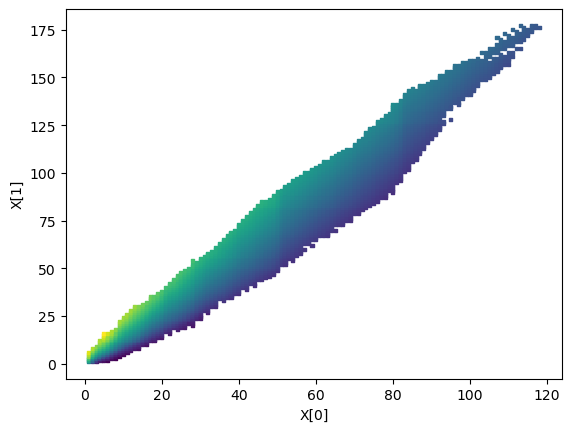

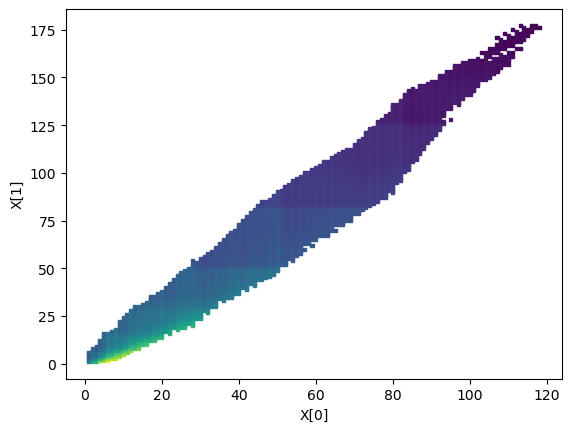

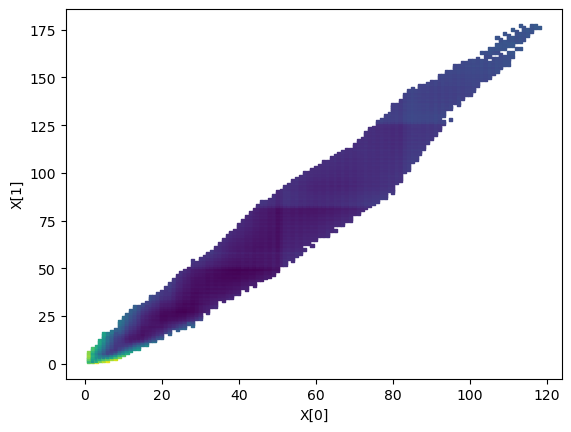

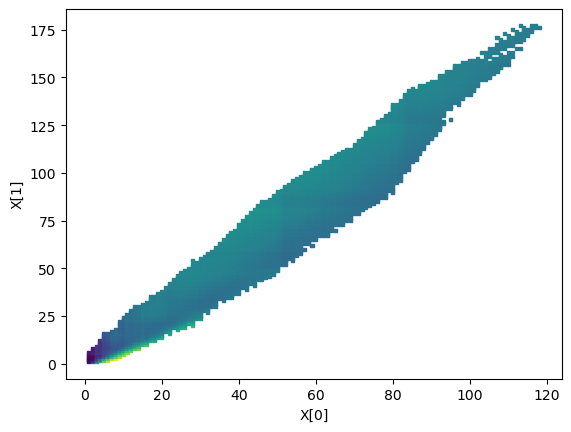

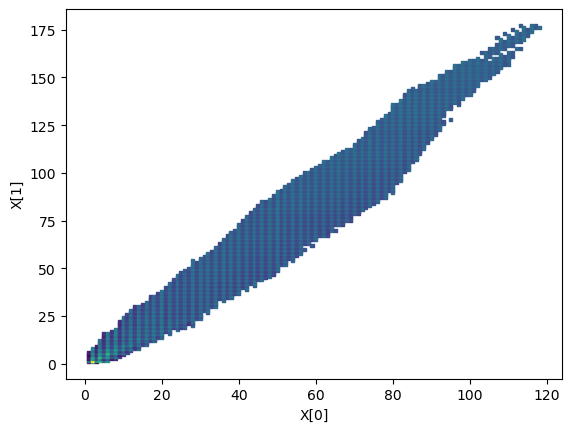

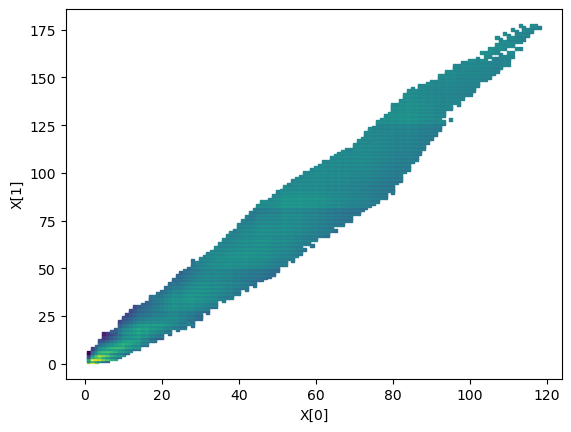

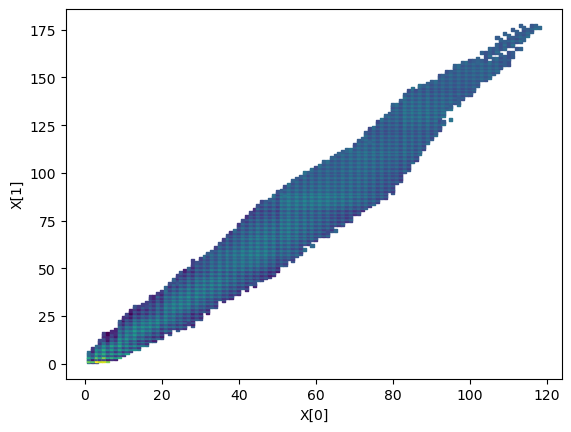

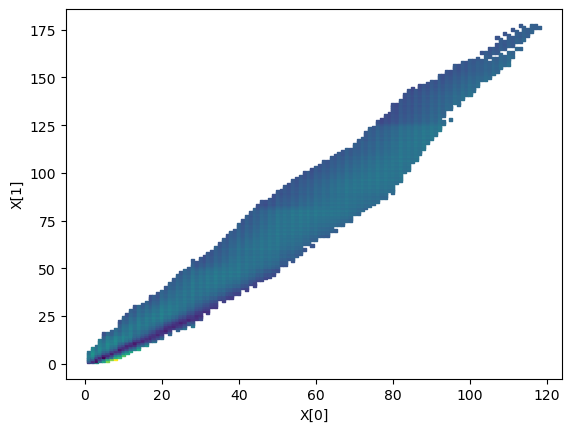

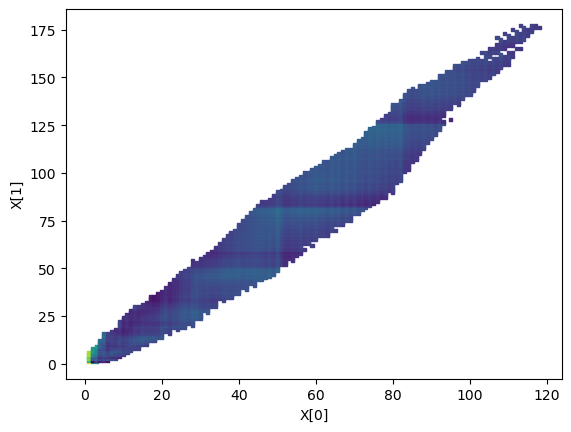

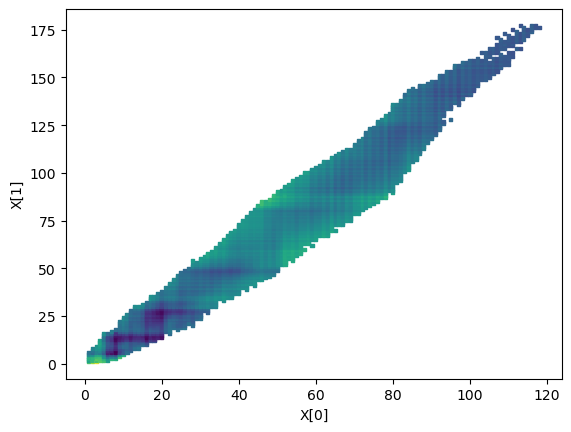

In [12]:
pca = PCA(n_components=10)
pca.fit(acts.detach().cpu().numpy())
acts_pca = pca.transform(acts.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

# visualize PCs as a function of X[0] and X[1]
for i in range(pca.n_components_):
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=acts_pca[:, i], s=5, marker='s')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.show()